# Data Observatory in cartoframes

The [Data Observatory](https://carto.com/data-observatory/) can be accessed through CARTOframes. This is a basic demonstration how one would pull down new measures for building a feature set for training a model.

In [1]:
%matplotlib inline
import cartoframes
from cartoframes import QueryLayer, Layer, styling
import pandas as pd

# Enter your username and api key below
cc = cartoframes.CartoContext(base_url='https://{username}.carto.com/'.format(username='nikleonidakis'),
                              api_key='3292af73f4256ea0fcdb316a09895460f5d7ac2e')

## Getting Mexico City Metro station coordinates

Use pandas to download an Excel spreadsheet into a dataframe.

In [2]:
# Metro stations from here:
#  https://github.com/josecarlosgonz/mexicoCityMetro/blob/master/coordsMetro.xlsx
df = pd.read_excel('https://github.com/josecarlosgonz/mexicoCityMetro/blob/master/coordsMetro.xlsx?raw=true')
df.head()

,Name,latitude,longitude,Unnamed: 3,linea,estacion,afluencia,latitude.1,longitude.1
0,Pantitlán,19.4163,-99.0747,NaN,1,Pantitlán,4513549.0,19.4163,-99.0747
1,Zaragoza,19.4117,-99.0821,NaN,1,Zaragoza,5144223.0,19.4117,-99.0821
2,Gómez Farías,19.4165,-99.0904,NaN,1,Gómez Farías,3665025.0,19.4165,-99.0904
3,Boulevard Puerto Aéreo,19.4196,-99.0963,NaN,1,Boulevard Puerto Aéreo,3611591.0,19.4196,-99.0963
4,Balbuena,19.4231,-99.1021,NaN,1,Balbuena,1822229.0,19.4231,-99.1021


Send to CARTO, being sure to specify the to-be-normalized column names `latitude.1` -> `latitude_1`, etc.

In [3]:
orig_table = 'coordsmetro_demo'
cc.write(df, orig_table, lnglat=('longitude_1', 'latitude_1'), overwrite=True)

The following columns were changed in the CARTO copy of this dataframe:
Name -> name
Unnamed: 3 -> unnamed_3
latitude.1 -> latitude_1
longitude.1 -> longitude_1
Table successfully written to CARTO: https://nikleonidakis.carto.com/dataset/coordsmetro_demo


## See the data by `linea`

_Note: notice the basemap labels are default on the bottom._

In [4]:
cc.map(layers=Layer(orig_table,
                    color={'column': 'linea',
                           'scheme': styling.bold(10)}))

See a static version of the map above

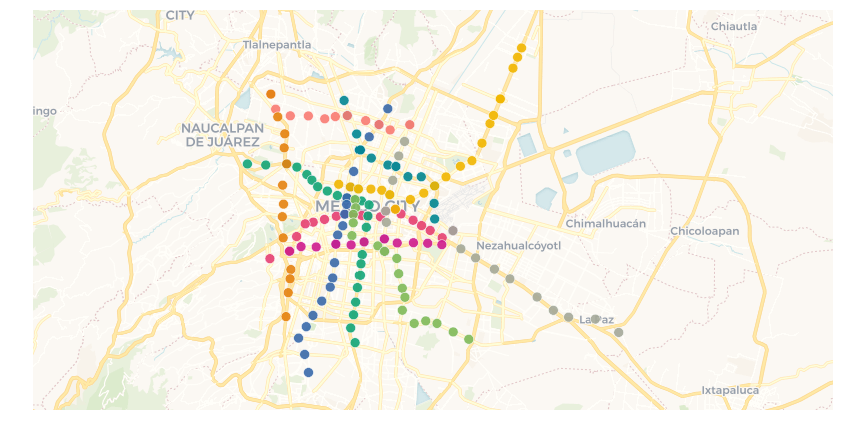

In [5]:
cc.map(layers=Layer(orig_table,
                    color={'column': 'linea',
                           'scheme': styling.bold(10)}),
       interactive=False)

## Data Observatory measures in the Mexico City area

Let's get education-related Data Observatory measures around the metro stops.

In [6]:
meta = cc.data_discovery(region=orig_table, keywords='education')
meta.head()

,denom_aggregate,denom_colname,denom_description,denom_geomref_colname,denom_id,denom_name,denom_reltype,denom_t_description,denom_tablename,denom_type,...,numer_timespan,numer_type,score,score_rank,score_rownum,suggested_name,target_area,target_geoms,timespan_rank,timespan_rownum
0,sum,employed,None,cvegeo,mx.inegi_columns.ECO4,Employed,denominator,None,obs_677076d10fcfa5de08aa726fd8d928dd4e54290e,Numeric,...,2010,Numeric,74.262562,1,1,employed_primary_education_2010,None,None,1,1
1,sum,employed,None,cvegeo,mx.inegi_columns.ECO4,Employed,denominator,None,obs_677076d10fcfa5de08aa726fd8d928dd4e54290e,Numeric,...,2010,Numeric,74.262562,1,1,employed_primary_education_2010_by_employed,None,None,1,1
2,sum,employed_primary_education,None,cvegeo,mx.inegi_columns.ECO10,Employed population with primary education,denominator,None,obs_bbbeed134ba68308a4fac833514e6b7a5e5bdf11,Numeric,...,2010,Numeric,36.600226,1,1,female_employed_primary_education_2010,None,None,1,1
3,sum,female_employed,None,cvegeo,mx.inegi_columns.ECO5,Employed female,denominator,None,obs_bbbeed134ba68308a4fac833514e6b7a5e5bdf11,Numeric,...,2010,Numeric,36.600226,1,2,female_employed_primary_education_2010,None,None,1,2
4,sum,employed_primary_education,None,cvegeo,mx.inegi_columns.ECO10,Employed population with primary education,denominator,None,obs_bbbeed134ba68308a4fac833514e6b7a5e5bdf11,Numeric,...,2010,Numeric,36.600226,1,1,female_employed_primary_education_2010_by_empl...,None,None,1,1


In [7]:
# See how many measures are possible
meta.shape

(50, 42)

In [8]:
# Look at the geometry levels available
meta.groupby('geom_id')['geom_id'].count()

geom_id
mx.inegi.ageb         10
mx.inegi.municipio    40
Name: geom_id, dtype: int64

Narrow down the problem to only have `municipio`-level measures.

In [9]:
# select only the municipio level data
meta = meta[meta['geom_id'] == 'mx.inegi.municipio']

This takes it down to only 20 measures.

In [10]:
meta.shape

(40, 42)

Take a look at the measures we have

In [11]:
meta['numer_name'].values

array(['Employed female population with primary education',
       'Employed female population with primary education',
       'Employed female population with primary education',
       'Employed female population with primary education',
       'Employed male population with primary education',
       'Employed male population with primary education',
       'Employed male population with primary education',
       'Employed male population with primary education',
       'Employed female population with incomplete secondary education',
       'Employed female population with incomplete secondary education',
       'Employed female population with incomplete secondary education',
       'Employed female population with incomplete secondary education',
       'Employed male population with incomplete secondary education',
       'Employed male population with incomplete secondary education',
       'Employed male population with incomplete secondary education',
       'Employed male p

In [15]:
cdb_service_quota_info()

NameError: name 'cdb_service_quota_info' is not defined

In [14]:
# Get some data
data = cc.data(orig_table, meta.loc[0:4])
data.head()

CartoException: ['cdb_dataservices_client._obs_getdata(5): [cdb_geocoder_server] REMOTE ERROR: Exception: You have reached the limit of your quota']

In [ ]:
new_table = 'mexico_metro_augmented'
cc.write(data, new_table, overwrite=True)

In [ ]:
from cartoframes import Layer, BaseMap, styling
cc.map(layers=[BaseMap('dark'), Layer(new_table,
                    color={'column': 'female_employed_incomplete_secondary_education_rate_2010',
                           'scheme': styling.sunset(7)})])